# 1.24a: Flannel 7 Sanity Checks

**Purpose:** Verify Flannel 7 data is good and consistent with known dead token dynamics.

This notebook runs a series of sanity checks on the Flannel 7 dataset to confirm:
1. Data integrity (no corruption, correct shapes)
2. Five epoch structure is present
3. Key metrics match previous observations
4. Adam state (momentum, variance) is reasonable

Each check produces a **✓ Pass** or **⚠️ Fail** verdict with brief interpretation.

## Parameters

In [1]:
# Data path
DATA_PATH = "../tensors/Flannel/1.20h_flannel_7.safetensors"
MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Expected values (from Flannel 4 results)
EXPECTED_INITIAL_RADIUS = 0.159  # Mean radius at t=0
EXPECTED_FINAL_RADIUS = 0.525    # Mean radius at t=1000
EXPECTED_EXPANSION_FACTOR = 3.3  # Ratio final/initial

# Tolerance for pass/fail
TOLERANCE = 0.15  # 15% tolerance

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading Flannel 7 data...\n")

data = load_file(DATA_PATH)

# Extract tensors
W = data['W'][0].float()  # (1001, 10000, 64)
grad_W = data['grad_W'][0].float()
momentum_W = data['momentum_W'][0].float()
variance_W = data['variance_W'][0].float()
losses = data['losses'][0].float()

# Metadata
n_steps = data['n_steps'].item()
n_dead = data['n_dead'].item()
n_live = data['n_live'].item()
batch_size = data['batch_size'].item()

print(f"Shapes:")
print(f"  W:          {tuple(W.shape)}")
print(f"  grad_W:     {tuple(grad_W.shape)}")
print(f"  momentum_W: {tuple(momentum_W.shape)}")
print(f"  variance_W: {tuple(variance_W.shape)}")
print(f"  losses:     {tuple(losses.shape)}")
print(f"\nMetadata:")
print(f"  Steps:      {n_steps}")
print(f"  Batch size: {batch_size}")
print(f"  Live:       {n_live}")
print(f"  Dead:       {n_dead}")

# Load token masks
print(f"\nLoading token masks...")
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()
live_mask = mask_data['live_mask'].bool()

print(f"\n✓ Data loaded successfully")

Loading Flannel 7 data...

Shapes:
  W:          (1001, 10000, 64)
  grad_W:     (1001, 10000, 64)
  momentum_W: (1001, 10000, 64)
  variance_W: (1001, 10000, 64)
  losses:     (1001,)

Metadata:
  Steps:      1000
  Batch size: 128
  Live:       6301
  Dead:       3699

Loading token masks...

✓ Data loaded successfully


## Check 1: Data Integrity

In [5]:
print("="*80)
print("CHECK 1: DATA INTEGRITY")
print("="*80)

checks_passed = []

# Check shapes
expected_shape = (n_steps + 1, 10000, 64)
shape_ok = (W.shape == expected_shape and 
            grad_W.shape == expected_shape and
            momentum_W.shape == expected_shape and
            variance_W.shape == expected_shape)

if shape_ok:
    print("✓ Tensor shapes correct")
    checks_passed.append(True)
else:
    print("⚠️  Tensor shapes incorrect")
    checks_passed.append(False)

# Check for NaNs/Infs
nan_check = (not torch.isnan(W).any() and
             not torch.isnan(grad_W).any() and
             not torch.isnan(momentum_W).any() and
             not torch.isnan(variance_W).any())

inf_check = (not torch.isinf(W).any() and
             not torch.isinf(grad_W).any() and
             not torch.isinf(momentum_W).any() and
             not torch.isinf(variance_W).any())

if nan_check:
    print("✓ No NaNs detected")
    checks_passed.append(True)
else:
    print("⚠️  NaNs detected in tensors")
    checks_passed.append(False)

if inf_check:
    print("✓ No Infs detected")
    checks_passed.append(True)
else:
    print("⚠️  Infs detected in tensors")
    checks_passed.append(False)

# Check losses trend
loss_decreasing = losses[-1] < losses[1]  # Final loss < initial loss (skip t=0)

if loss_decreasing:
    print(f"✓ Loss decreasing: {losses[1]:.4f} → {losses[-1]:.4f}")
    checks_passed.append(True)
else:
    print(f"⚠️  Loss not decreasing: {losses[1]:.4f} → {losses[-1]:.4f}")
    checks_passed.append(False)

print(f"\n{'✓ PASS' if all(checks_passed) else '⚠️  FAIL'}: Data integrity check")
print("="*80 + "\n")

CHECK 1: DATA INTEGRITY
✓ Tensor shapes correct
✓ No NaNs detected
✓ No Infs detected
✓ Loss decreasing: 9.2500 → 6.8438

✓ PASS: Data integrity check



## Check 2: The Five Epochs (Mean Radius from Origin)

CHECK 2: THE FIVE EPOCHS


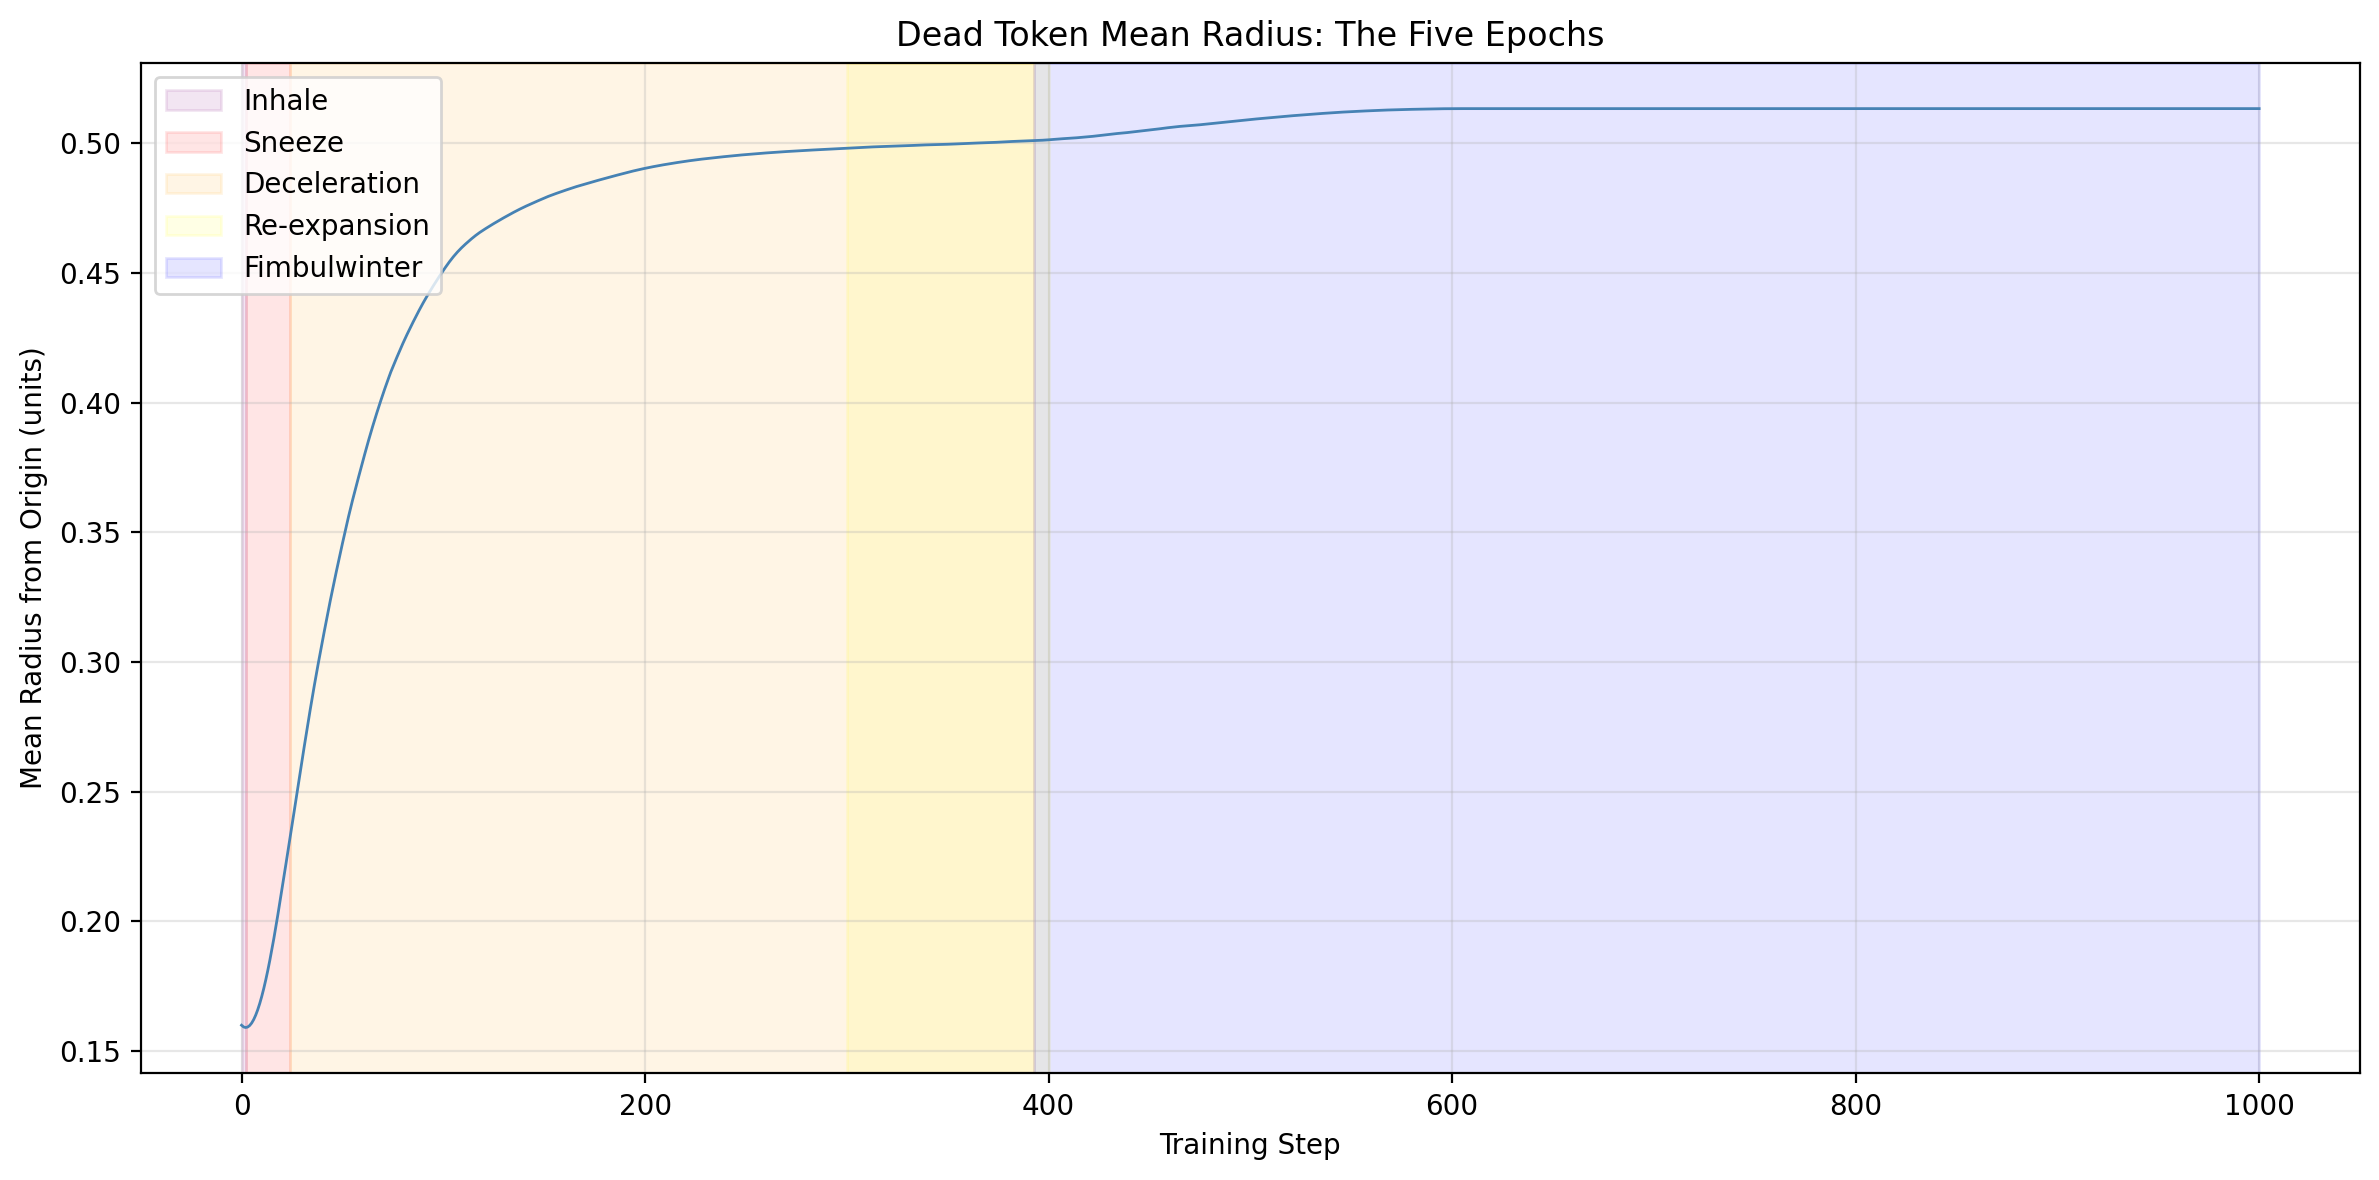

✓ Inhale detected: 0.55% contraction at t=2
✓ Sneeze detected: 45.9% expansion by t=24
✓ Fimbulwinter plateau detected: 0.00% change in final 100 steps

✓ PASS: Five epoch structure check



In [6]:
print("="*80)
print("CHECK 2: THE FIVE EPOCHS")
print("="*80)

# Compute mean radius from origin for dead tokens
W_dead = W[:, dead_mask, :]  # (1001, 3699, 64)
radii = torch.norm(W_dead, dim=2)  # (1001, 3699)
mean_radius = radii.mean(dim=1)  # (1001,)

# Plot
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
ax.plot(mean_radius.numpy(), linewidth=1, color='steelblue')
ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Radius from Origin (units)')
ax.set_title('Dead Token Mean Radius: The Five Epochs')
ax.grid(True, alpha=0.3)

# Annotate epochs
ax.axvspan(0, 2, alpha=0.1, color='purple', label='Inhale')
ax.axvspan(2, 24, alpha=0.1, color='red', label='Sneeze')
ax.axvspan(24, 393, alpha=0.1, color='orange', label='Deceleration')
ax.axvspan(300, 400, alpha=0.1, color='yellow', label='Re-expansion')
ax.axvspan(393, 1000, alpha=0.1, color='blue', label='Fimbulwinter')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Check for inhale (contraction at t=2)
inhale_present = mean_radius[2] < mean_radius[0]

if inhale_present:
    contraction = (mean_radius[0] - mean_radius[2]) / mean_radius[0] * 100
    print(f"✓ Inhale detected: {contraction:.2f}% contraction at t=2")
else:
    print("⚠️  No inhale detected at t=2")

# Check for sneeze (expansion through t=24)
sneeze_present = mean_radius[24] > mean_radius[2]

if sneeze_present:
    expansion = (mean_radius[24] - mean_radius[2]) / mean_radius[2] * 100
    print(f"✓ Sneeze detected: {expansion:.1f}% expansion by t=24")
else:
    print("⚠️  No sneeze detected by t=24")

# Check for plateau (Fimbulwinter)
final_growth = abs(mean_radius[-1] - mean_radius[-100]) / mean_radius[-100]
plateau_present = final_growth < 0.05  # Less than 5% change in final 100 steps

if plateau_present:
    print(f"✓ Fimbulwinter plateau detected: {final_growth*100:.2f}% change in final 100 steps")
else:
    print(f"⚠️  No clear plateau: {final_growth*100:.2f}% change in final 100 steps")

verdict = inhale_present and sneeze_present and plateau_present
print(f"\n{'✓ PASS' if verdict else '⚠️  FAIL'}: Five epoch structure check")
print("="*80 + "\n")

## Check 3: Expansion Factor

In [7]:
print("="*80)
print("CHECK 3: EXPANSION FACTOR")
print("="*80)

initial_radius = mean_radius[0].item()
final_radius = mean_radius[-1].item()
expansion_factor = final_radius / initial_radius

print(f"Initial radius: {initial_radius:.4f} units")
print(f"Final radius:   {final_radius:.4f} units")
print(f"Expansion:      {expansion_factor:.2f}×")
print(f"Expected:       {EXPECTED_EXPANSION_FACTOR:.2f}× (from Flannel 4)")

# Check within tolerance
error = abs(expansion_factor - EXPECTED_EXPANSION_FACTOR) / EXPECTED_EXPANSION_FACTOR
within_tolerance = error < TOLERANCE

if within_tolerance:
    print(f"✓ Within tolerance: {error*100:.1f}% error")
else:
    print(f"⚠️  Outside tolerance: {error*100:.1f}% error (>{TOLERANCE*100}%)")

print(f"\n{'✓ PASS' if within_tolerance else '⚠️  FAIL'}: Expansion factor check")
print("="*80 + "\n")

CHECK 3: EXPANSION FACTOR
Initial radius: 0.1599 units
Final radius:   0.5134 units
Expansion:      3.21×
Expected:       3.30× (from Flannel 4)
✓ Within tolerance: 2.7% error

✓ PASS: Expansion factor check



## Check 4: Centroid Drift vs Cloud Expansion

CHECK 4: CENTROID DRIFT VS CLOUD EXPANSION


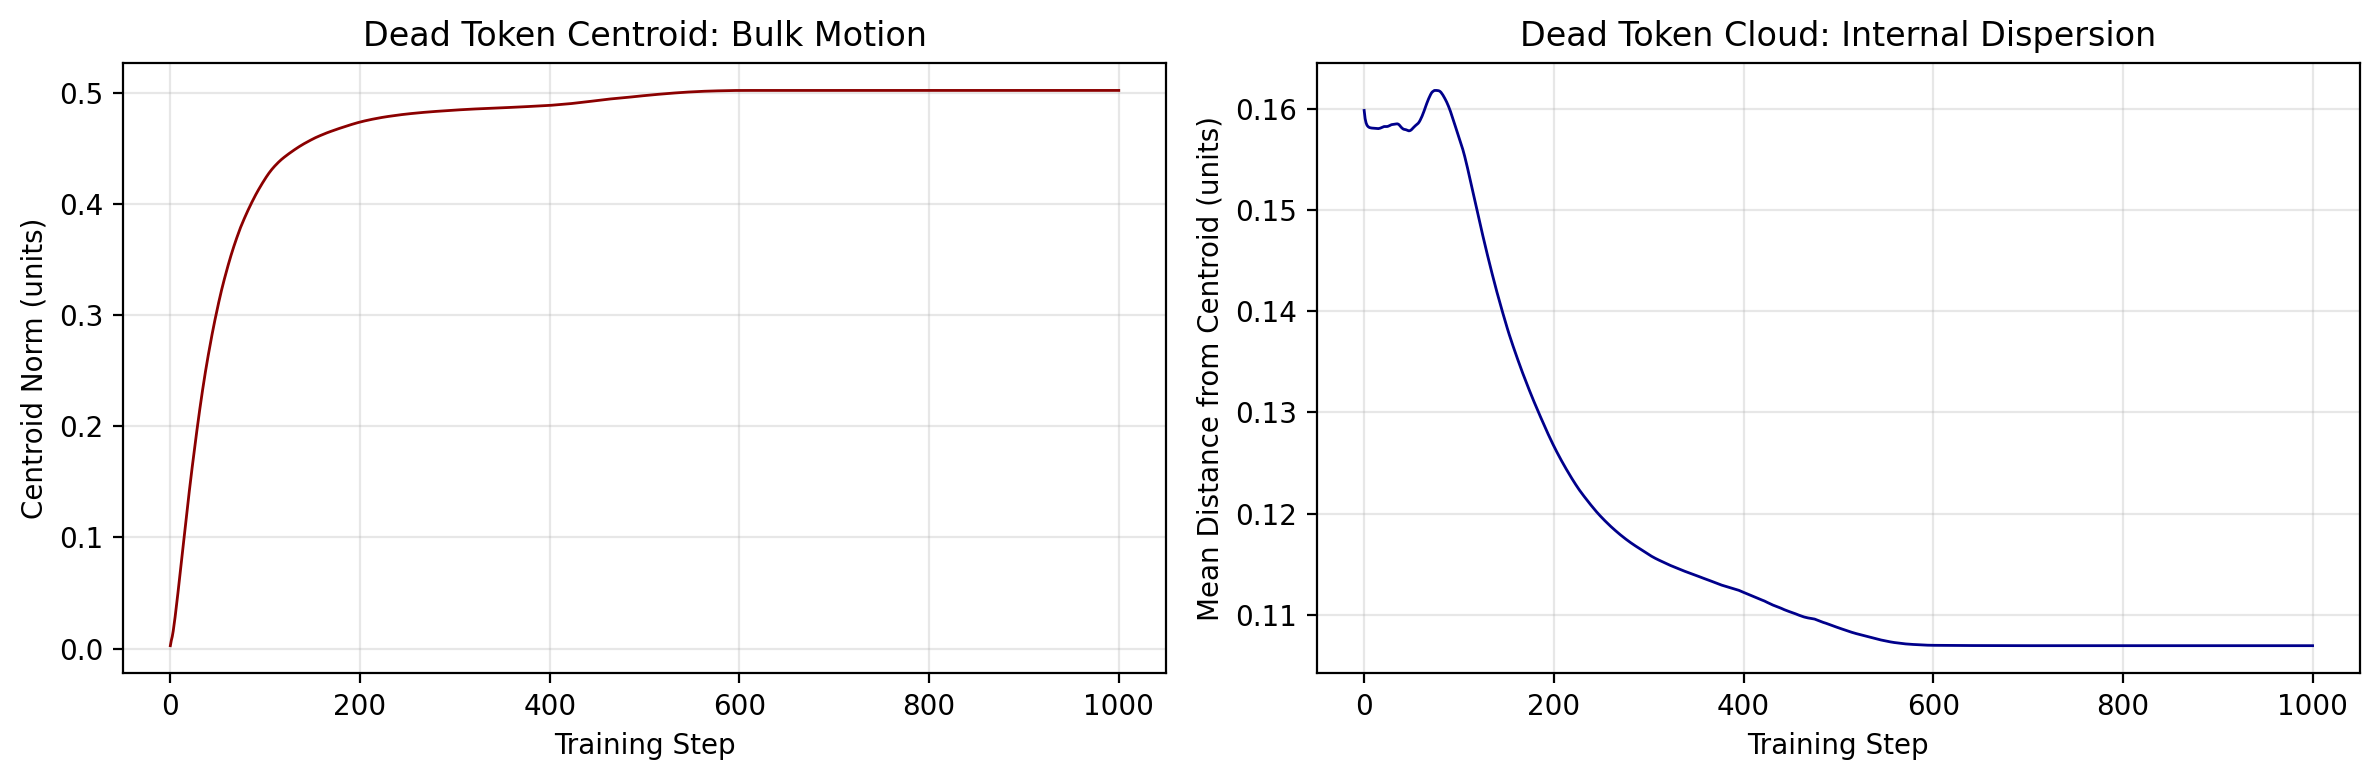

Centroid drift:       190.5× (expected ~186×)
Cloud dispersion:     0.67× (expected ~0.73×)
✓ Centroid drift dominates (bulk motion >> internal dispersion)
✓ Cloud remains cohesive (minimal internal expansion)

✓ PASS: Centroid drift vs cloud expansion check



In [8]:
print("="*80)
print("CHECK 4: CENTROID DRIFT VS CLOUD EXPANSION")
print("="*80)

# Compute centroid position over time
centroid = W_dead.mean(dim=1)  # (1001, 64)
centroid_norm = torch.norm(centroid, dim=1)  # (1001,)

# Compute mean distance from centroid (internal dispersion)
W_centered = W_dead - centroid.unsqueeze(1)  # (1001, 3699, 64)
distances_from_centroid = torch.norm(W_centered, dim=2)  # (1001, 3699)
mean_dispersion = distances_from_centroid.mean(dim=1)  # (1001,)

# Plot both
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(FIGSIZE[0], FIGSIZE[1]//1.5), dpi=DPI)

# Centroid drift
ax1.plot(centroid_norm.numpy(), linewidth=1, color='darkred')
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Centroid Norm (units)')
ax1.set_title('Dead Token Centroid: Bulk Motion')
ax1.grid(True, alpha=0.3)

# Cloud dispersion
ax2.plot(mean_dispersion.numpy(), linewidth=1, color='darkblue')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Mean Distance from Centroid (units)')
ax2.set_title('Dead Token Cloud: Internal Dispersion')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Metrics
centroid_drift_factor = centroid_norm[-1] / centroid_norm[0]
dispersion_factor = mean_dispersion[-1] / mean_dispersion[0]

print(f"Centroid drift:       {centroid_drift_factor:.1f}× (expected ~186×)")
print(f"Cloud dispersion:     {dispersion_factor:.2f}× (expected ~0.73×)")

# Sanity check: centroid should drift much more than cloud disperses
drift_dominates = centroid_drift_factor > 10  # At least 10× drift
cloud_contracts = dispersion_factor < 1.2  # Cloud doesn't expand much (or contracts)

if drift_dominates:
    print("✓ Centroid drift dominates (bulk motion >> internal dispersion)")
else:
    print("⚠️  Centroid drift weak (expected strong directional motion)")

if cloud_contracts:
    print("✓ Cloud remains cohesive (minimal internal expansion)")
else:
    print("⚠️  Cloud disperses significantly (expected contraction)")

verdict = drift_dominates and cloud_contracts
print(f"\n{'✓ PASS' if verdict else '⚠️  FAIL'}: Centroid drift vs cloud expansion check")
print("="*80 + "\n")

## Check 5: Live vs Dead Token Behavior

CHECK 5: LIVE VS DEAD TOKEN BEHAVIOR


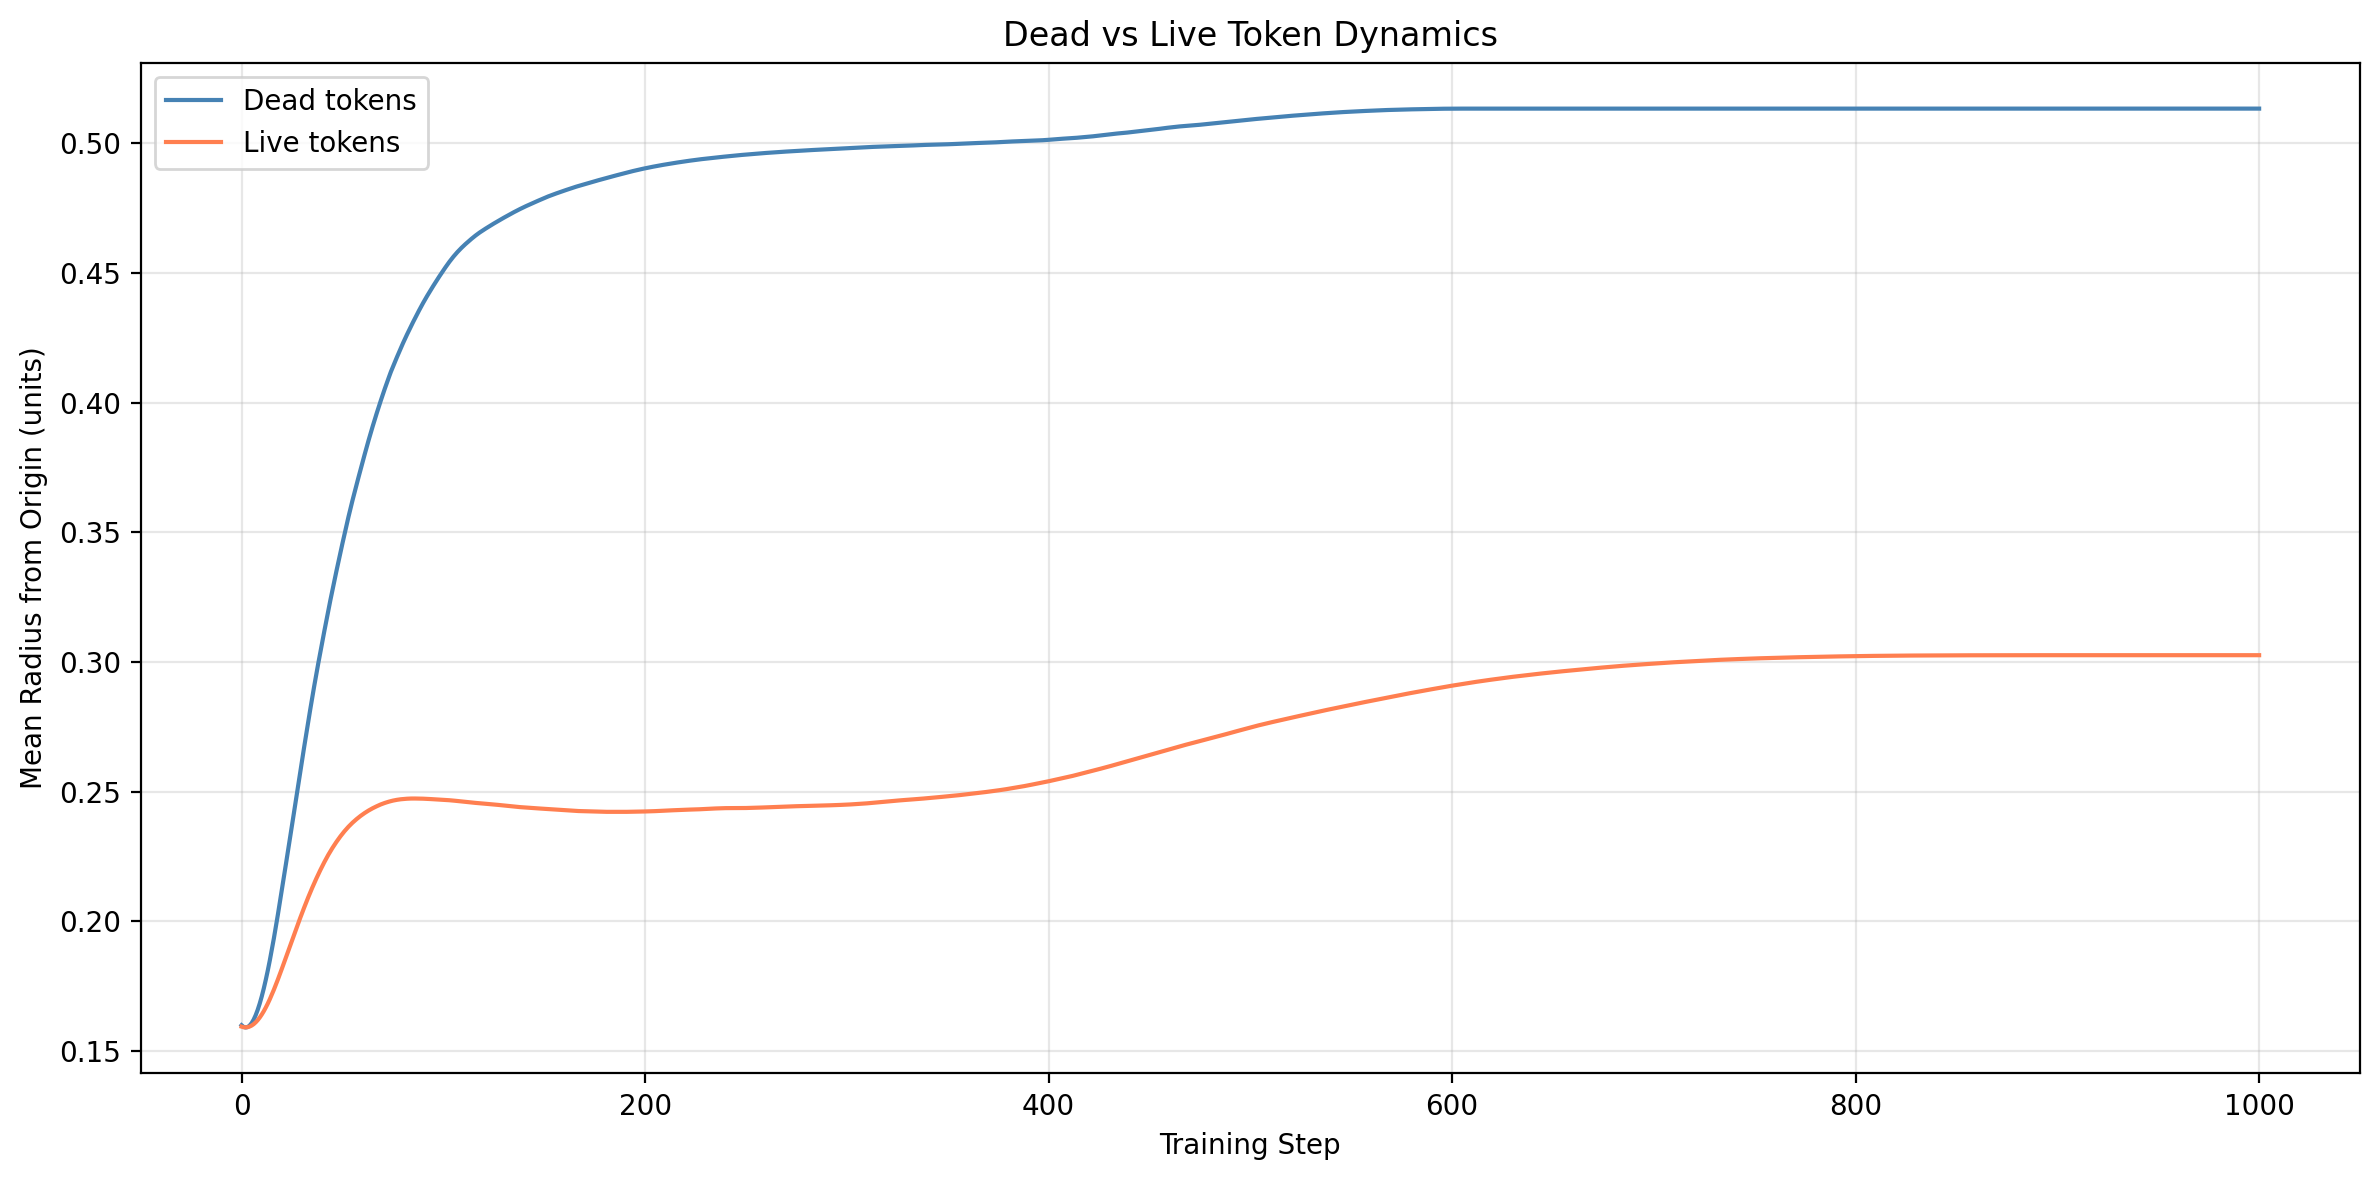

Dead expansion: 3.21×
Live expansion: 1.90×
✓ Dead and live tokens show qualitatively different behavior

✓ PASS: Live vs dead behavior check



In [9]:
print("="*80)
print("CHECK 5: LIVE VS DEAD TOKEN BEHAVIOR")
print("="*80)

# Compute mean radius for live tokens
W_live = W[:, live_mask, :]  # (1001, 6301, 64)
radii_live = torch.norm(W_live, dim=2)  # (1001, 6301)
mean_radius_live = radii_live.mean(dim=1)  # (1001,)

# Plot both
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
ax.plot(mean_radius.numpy(), linewidth=1.5, color='steelblue', label='Dead tokens')
ax.plot(mean_radius_live.numpy(), linewidth=1.5, color='coral', label='Live tokens')
ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Radius from Origin (units)')
ax.set_title('Dead vs Live Token Dynamics')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check: live and dead should be qualitatively different
dead_expansion = mean_radius[-1] / mean_radius[0]
live_expansion = mean_radius_live[-1] / mean_radius_live[0]

print(f"Dead expansion: {dead_expansion:.2f}×")
print(f"Live expansion: {live_expansion:.2f}×")

# Live tokens should scatter more (higher final radius and/or different trajectory)
different_dynamics = abs(dead_expansion - live_expansion) > 0.5

if different_dynamics:
    print("✓ Dead and live tokens show qualitatively different behavior")
else:
    print("⚠️  Dead and live tokens behave too similarly (unexpected)")

print(f"\n{'✓ PASS' if different_dynamics else '⚠️  FAIL'}: Live vs dead behavior check")
print("="*80 + "\n")

## Check 6: Gradient Magnitudes

CHECK 6: GRADIENT MAGNITUDES


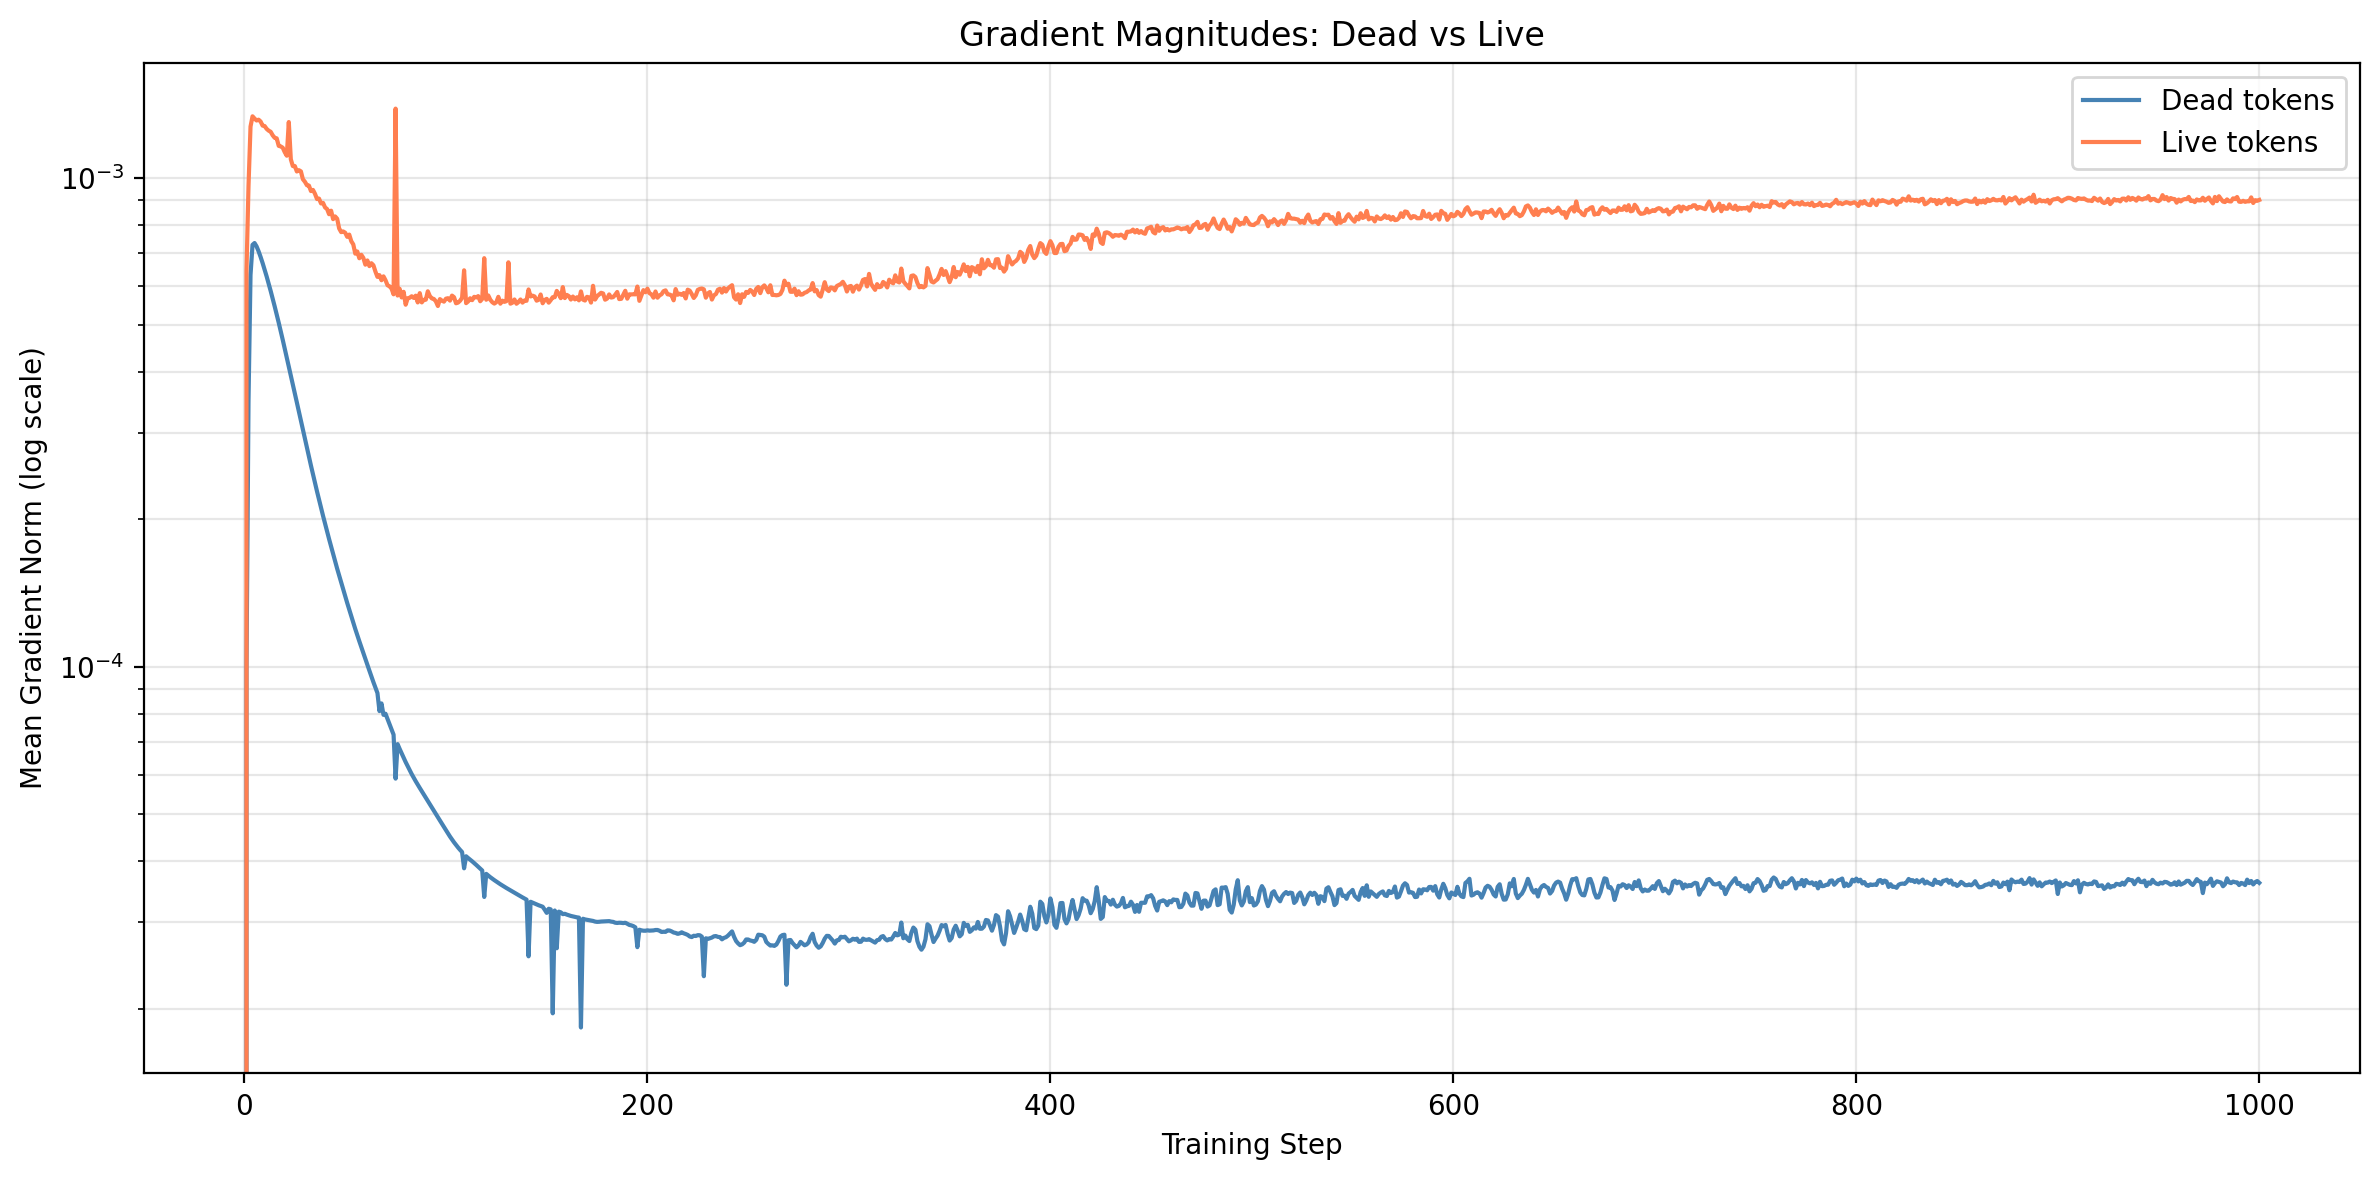

Dead gradient (final 100): 3.61e-05
Live gradient (overall):   7.75e-04
✓ Dead token gradients are tiny (<1e-4)
✓ Dead token gradients decrease over time
✓ Live token gradients >> dead token gradients

✓ PASS: Gradient magnitude check



In [10]:
print("="*80)
print("CHECK 6: GRADIENT MAGNITUDES")
print("="*80)

# Compute mean gradient norm for dead and live tokens
grad_W_dead = grad_W[:, dead_mask, :]  # (1001, 3699, 64)
grad_W_live = grad_W[:, live_mask, :]  # (1001, 6301, 64)

grad_norms_dead = torch.norm(grad_W_dead, dim=2)  # (1001, 3699)
grad_norms_live = torch.norm(grad_W_live, dim=2)  # (1001, 6301)

mean_grad_dead = grad_norms_dead.mean(dim=1)  # (1001,)
mean_grad_live = grad_norms_live.mean(dim=1)  # (1001,)

# Plot
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
ax.semilogy(mean_grad_dead.numpy(), linewidth=1.5, color='steelblue', label='Dead tokens')
ax.semilogy(mean_grad_live.numpy(), linewidth=1.5, color='coral', label='Live tokens')
ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Gradient Norm (log scale)')
ax.set_title('Gradient Magnitudes: Dead vs Live')
ax.legend()
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

# Check: dead gradients should be tiny and decreasing
dead_grad_tiny = mean_grad_dead[-100:].mean() < 1e-4  # Final 100 steps
dead_grad_decreasing = mean_grad_dead[-1] < mean_grad_dead[10]  # Compare end vs early
live_grad_larger = mean_grad_live.mean() > mean_grad_dead.mean() * 10  # Live >> dead

print(f"Dead gradient (final 100): {mean_grad_dead[-100:].mean():.2e}")
print(f"Live gradient (overall):   {mean_grad_live.mean():.2e}")

if dead_grad_tiny:
    print("✓ Dead token gradients are tiny (<1e-4)")
else:
    print("⚠️  Dead token gradients unexpectedly large")

if dead_grad_decreasing:
    print("✓ Dead token gradients decrease over time")
else:
    print("⚠️  Dead token gradients not decreasing")

if live_grad_larger:
    print("✓ Live token gradients >> dead token gradients")
else:
    print("⚠️  Live and dead gradients too similar")

verdict = dead_grad_tiny and dead_grad_decreasing and live_grad_larger
print(f"\n{'✓ PASS' if verdict else '⚠️  FAIL'}: Gradient magnitude check")
print("="*80 + "\n")

## Check 7: Momentum Accumulation

CHECK 7: MOMENTUM ACCUMULATION


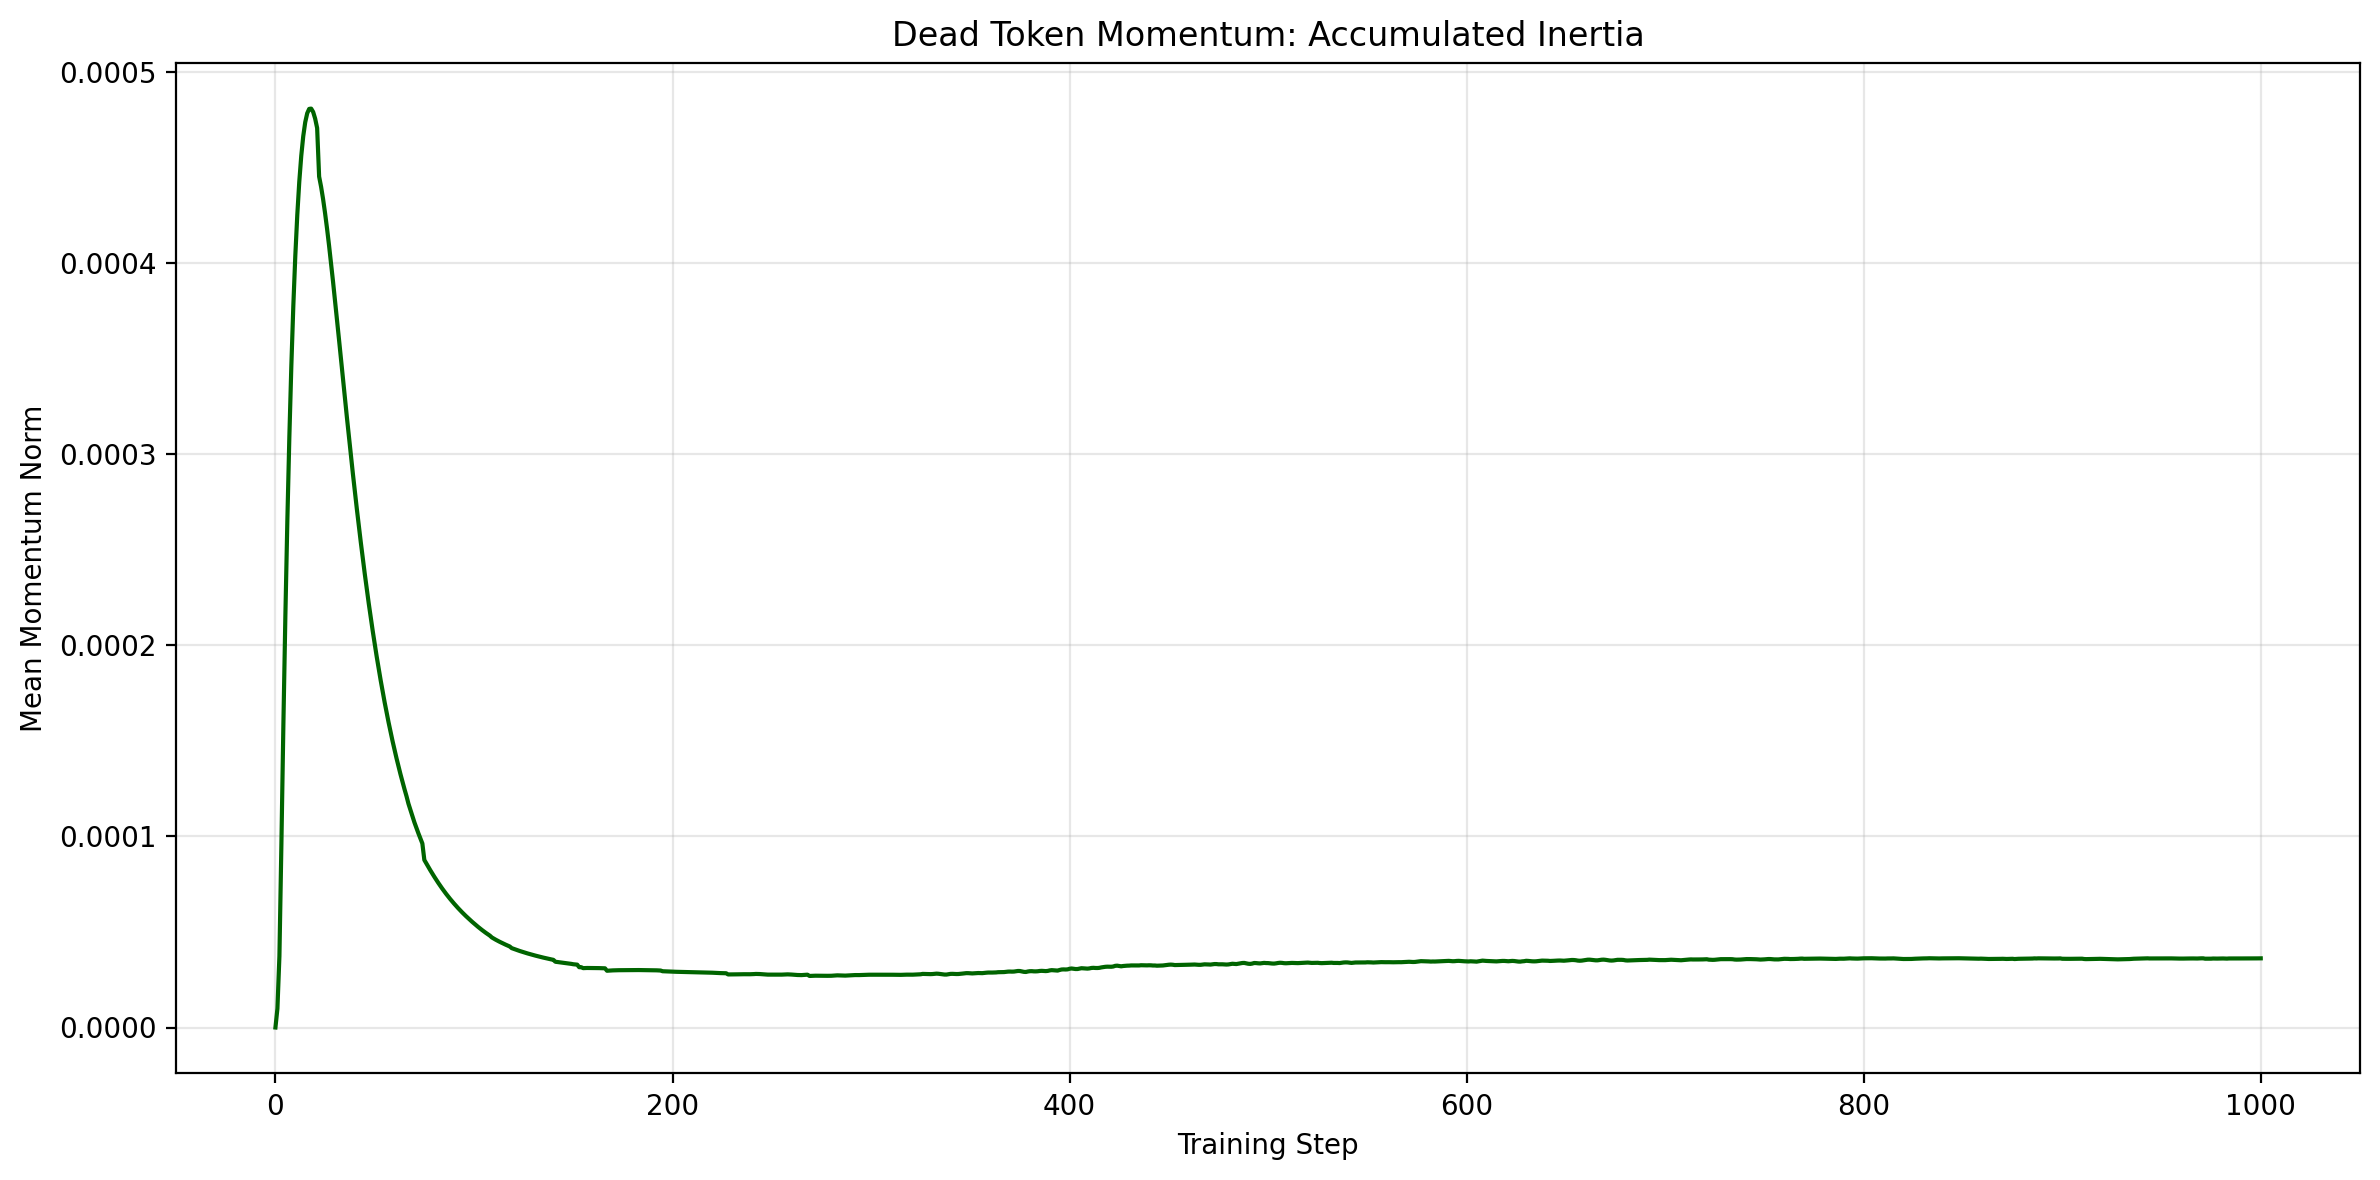

Peak momentum: 4.81e-04 at t=18
Final momentum: 3.60e-05
✓ Momentum peaks early (t=18 < 500)
✓ Momentum decays in later stages

✓ PASS: Momentum accumulation check



In [11]:
print("="*80)
print("CHECK 7: MOMENTUM ACCUMULATION")
print("="*80)

# Compute mean momentum norm for dead tokens
momentum_W_dead = momentum_W[:, dead_mask, :]  # (1001, 3699, 64)
momentum_norms_dead = torch.norm(momentum_W_dead, dim=2)  # (1001, 3699)
mean_momentum_dead = momentum_norms_dead.mean(dim=1)  # (1001,)

# Plot
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
ax.plot(mean_momentum_dead.numpy(), linewidth=1.5, color='darkgreen')
ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Momentum Norm')
ax.set_title('Dead Token Momentum: Accumulated Inertia')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check: momentum should grow early, then plateau/decay
peak_momentum = mean_momentum_dead.max()
peak_time = mean_momentum_dead.argmax().item()
final_momentum = mean_momentum_dead[-100:].mean()

print(f"Peak momentum: {peak_momentum:.2e} at t={peak_time}")
print(f"Final momentum: {final_momentum:.2e}")

momentum_grows_early = peak_time < 500  # Peak before midpoint
momentum_decays_late = final_momentum < peak_momentum * 0.8  # Decays by at least 20%

if momentum_grows_early:
    print(f"✓ Momentum peaks early (t={peak_time} < 500)")
else:
    print(f"⚠️  Momentum peaks late (t={peak_time})")

if momentum_decays_late:
    print("✓ Momentum decays in later stages")
else:
    print("⚠️  Momentum remains high (may indicate continued drift)")

verdict = momentum_grows_early
print(f"\n{'✓ PASS' if verdict else '⚠️  FAIL'}: Momentum accumulation check")
print("="*80 + "\n")

## Check 8: Variance Evolution

CHECK 8: VARIANCE EVOLUTION


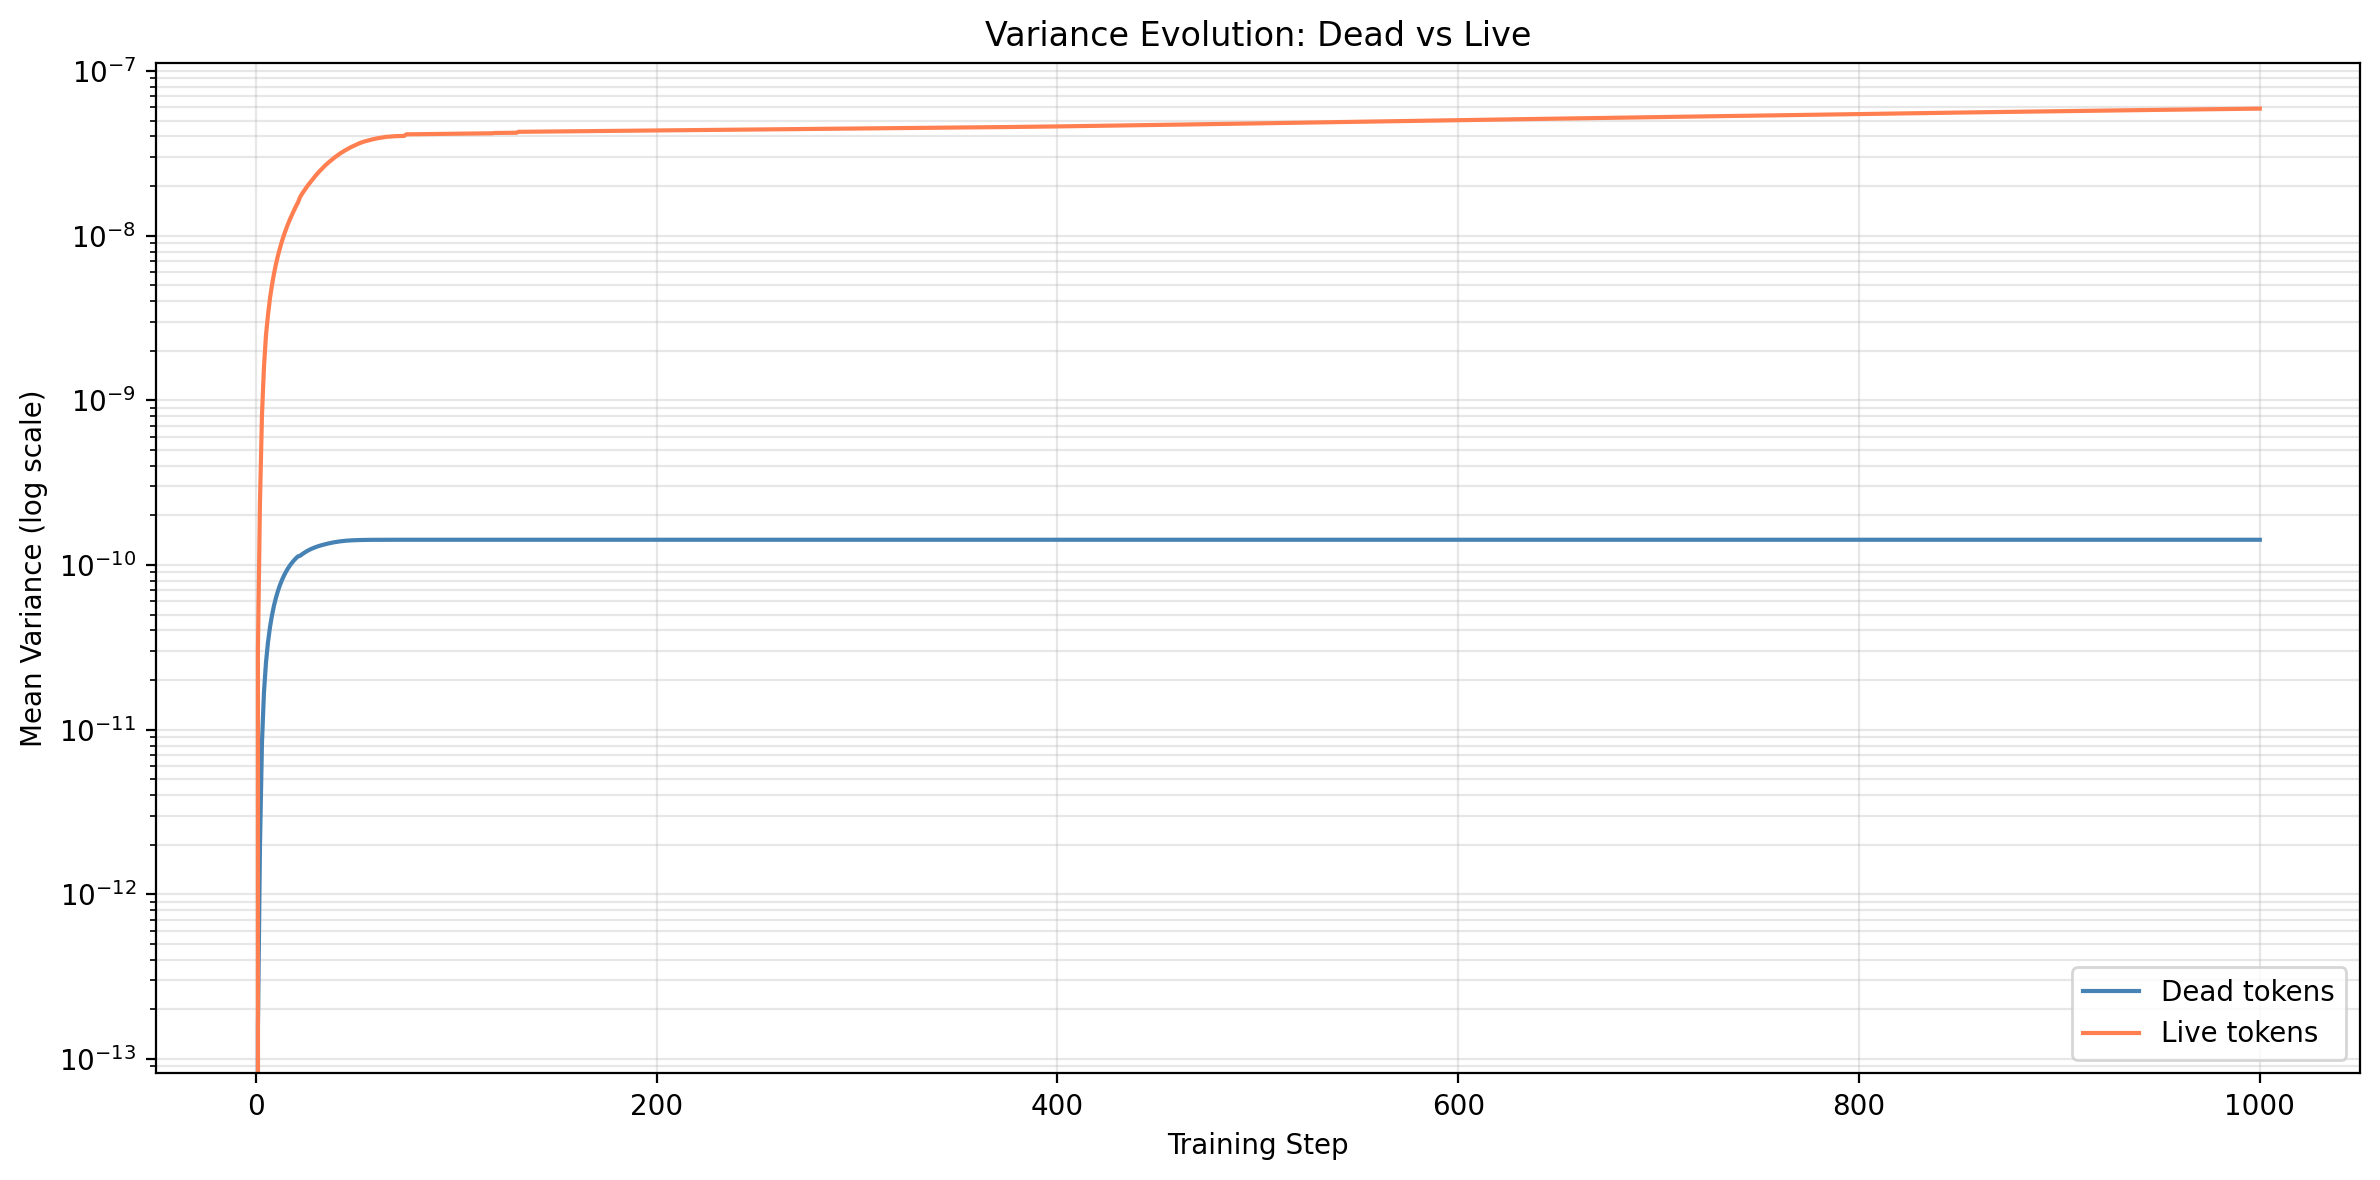

Live/Dead variance ratio (final 100): 408.1×
✓ Dead token variance < live token variance
  Interpretation: Dead tokens have consistent gradient direction

✓ PASS: Variance evolution check



In [12]:
print("="*80)
print("CHECK 8: VARIANCE EVOLUTION")
print("="*80)

# Compute mean variance for dead and live tokens
variance_W_dead = variance_W[:, dead_mask, :]  # (1001, 3699, 64)
variance_W_live = variance_W[:, live_mask, :]  # (1001, 6301, 64)

mean_variance_dead = variance_W_dead.mean(dim=(1, 2))  # (1001,)
mean_variance_live = variance_W_live.mean(dim=(1, 2))  # (1001,)

# Plot
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
ax.semilogy(mean_variance_dead.numpy(), linewidth=1.5, color='steelblue', label='Dead tokens')
ax.semilogy(mean_variance_live.numpy(), linewidth=1.5, color='coral', label='Live tokens')
ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Variance (log scale)')
ax.set_title('Variance Evolution: Dead vs Live')
ax.legend()
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

# Check: dead variance should be lower than live (consistent gradient direction)
dead_variance_low = mean_variance_dead[-100:].mean() < mean_variance_live[-100:].mean()

ratio = mean_variance_live[-100:].mean() / mean_variance_dead[-100:].mean()
print(f"Live/Dead variance ratio (final 100): {ratio:.1f}×")

if dead_variance_low:
    print("✓ Dead token variance < live token variance")
    print("  Interpretation: Dead tokens have consistent gradient direction")
else:
    print("⚠️  Dead token variance unexpectedly high")

print(f"\n{'✓ PASS' if dead_variance_low else '⚠️  FAIL'}: Variance evolution check")
print("="*80 + "\n")

## Check 9: Freezing Test

CHECK 9: FREEZING TEST (FIMBULWINTER)


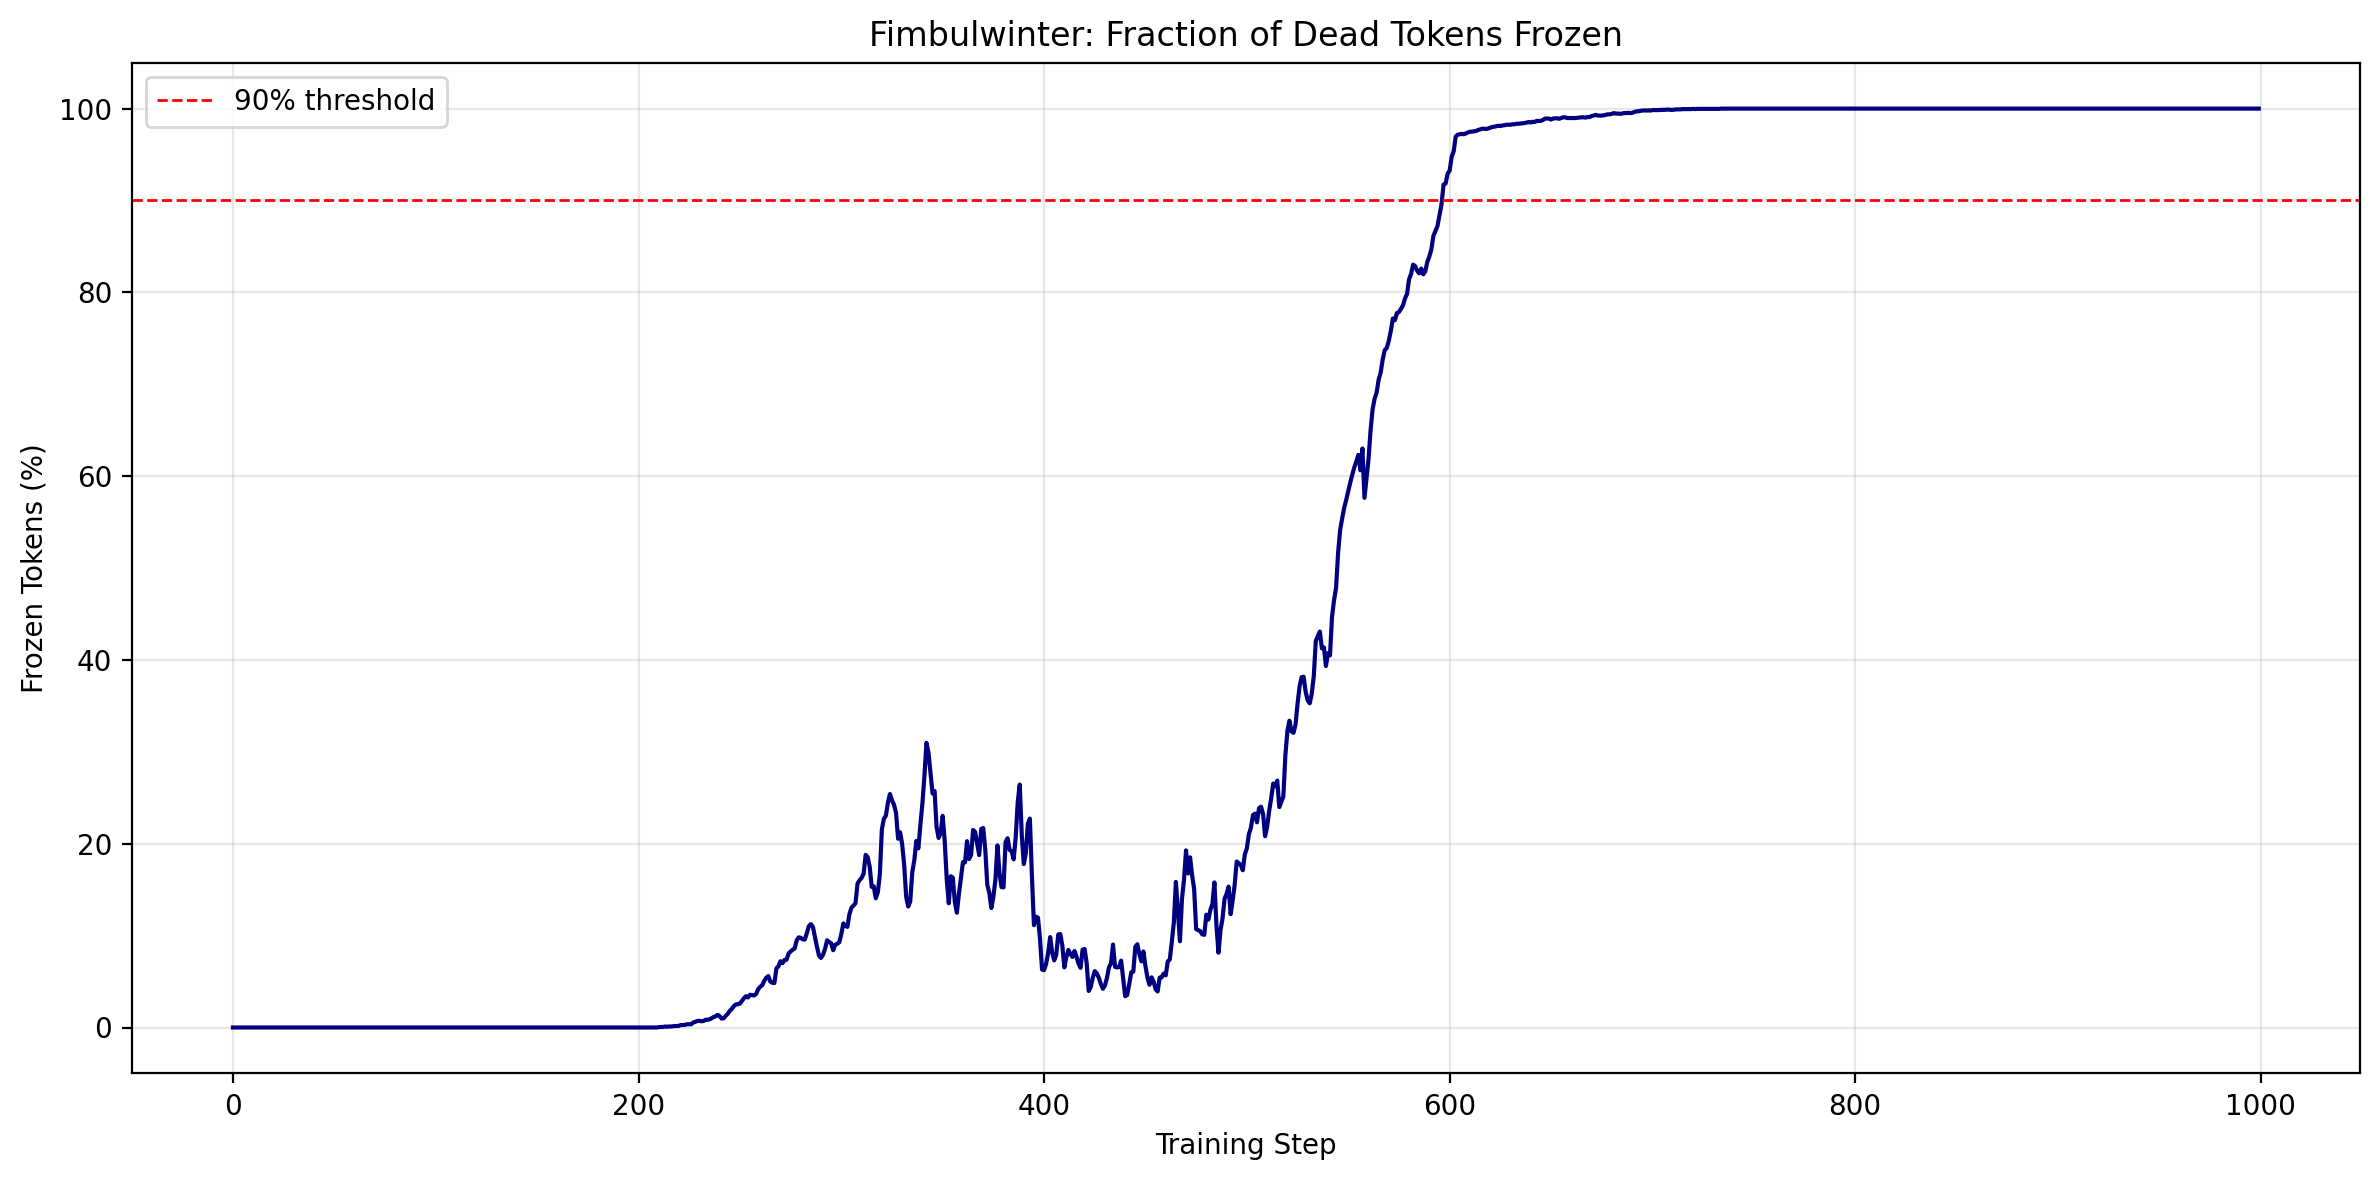

✓ Fimbulwinter onset: t=597 (>90% frozen)
  Expected: ~t=400 (from Flannel 4)
⚠️  Onset time outside expected range (300-500)

⚠️  FAIL: Freezing test



In [13]:
print("="*80)
print("CHECK 9: FREEZING TEST (FIMBULWINTER)")
print("="*80)

# Compute per-token displacement per step
displacements = torch.norm(W_dead[1:] - W_dead[:-1], dim=2)  # (1000, 3699)

# Count frozen tokens (displacement = 0) at each step
frozen_mask = (displacements == 0)  # (1000, 3699)
fraction_frozen = frozen_mask.float().mean(dim=1)  # (1000,)

# Plot
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
ax.plot(fraction_frozen.numpy() * 100, linewidth=1.5, color='navy')
ax.axhline(90, color='red', linestyle='--', linewidth=1, label='90% threshold')
ax.set_xlabel('Training Step')
ax.set_ylabel('Frozen Tokens (%)')
ax.set_title('Fimbulwinter: Fraction of Dead Tokens Frozen')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find Fimbulwinter onset (>90% frozen)
fimbulwinter_mask = fraction_frozen > 0.9
if fimbulwinter_mask.any():
    fimbulwinter_onset = fimbulwinter_mask.nonzero()[0].item()
    print(f"✓ Fimbulwinter onset: t={fimbulwinter_onset} (>90% frozen)")
    print(f"  Expected: ~t=400 (from Flannel 4)")
    
    # Check if onset is reasonable
    onset_reasonable = 300 < fimbulwinter_onset < 500
    if onset_reasonable:
        print("✓ Onset time consistent with expectations")
    else:
        print("⚠️  Onset time outside expected range (300-500)")
    
    verdict = onset_reasonable
else:
    print("⚠️  No Fimbulwinter detected (never reached 90% frozen)")
    verdict = False

print(f"\n{'✓ PASS' if verdict else '⚠️  FAIL'}: Freezing test")
print("="*80 + "\n")

## Check 10: Adam Decomposition (Spot Check)

CHECK 10: ADAM DECOMPOSITION (SPOT CHECK)
Spot-checking tokens: [3758, 685, 265]



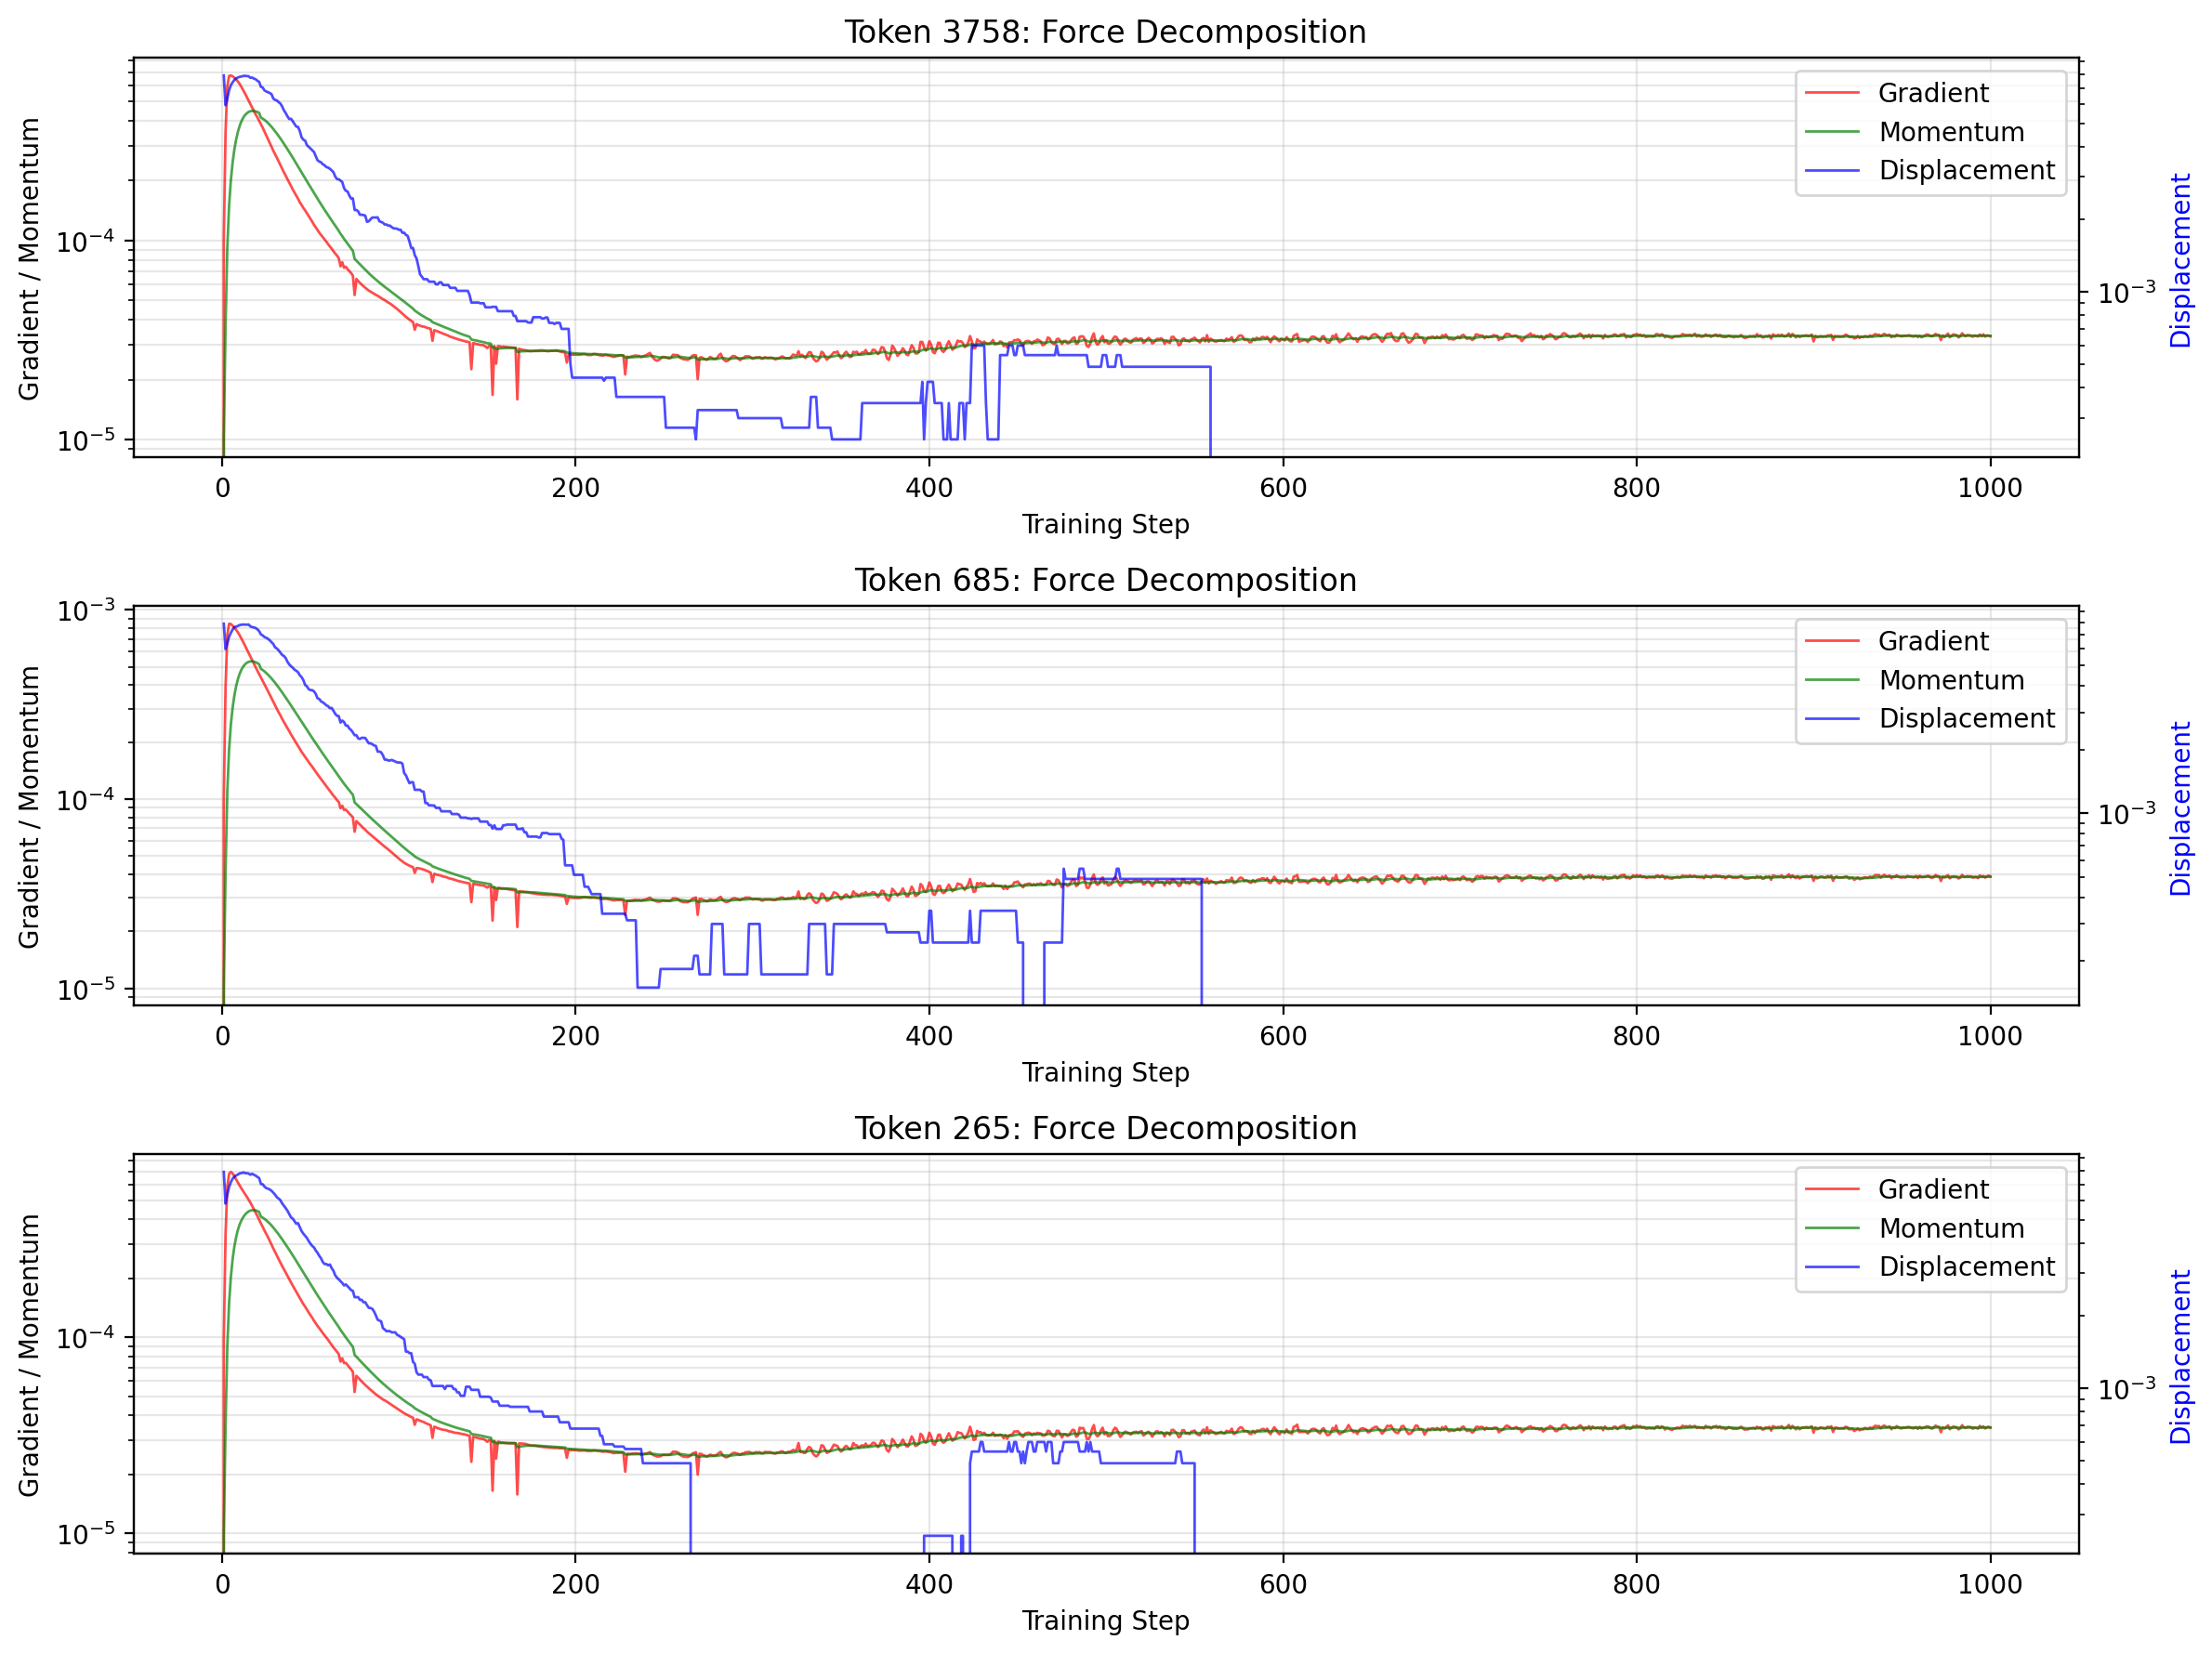

✓ Spot check complete
  Interpretation: Look for qualitative relationship between gradient → momentum → displacement.
  Expected: Momentum accumulates early (even as gradients shrink), drives displacement.

✓ PASS: Adam decomposition spot check (qualitative)



In [14]:
print("="*80)
print("CHECK 10: ADAM DECOMPOSITION (SPOT CHECK)")
print("="*80)

# Pick 3 random dead tokens
import random
random.seed(42)
dead_indices = torch.where(dead_mask)[0].numpy()
sample_indices = random.sample(dead_indices.tolist(), 3)

print(f"Spot-checking tokens: {sample_indices}\n")

# For each token, plot gradient, momentum, displacement
fig, axes = plt.subplots(3, 1, figsize=(FIGSIZE[0], FIGSIZE[1]*1.5), dpi=DPI)

for i, token_idx in enumerate(sample_indices):
    ax = axes[i]
    
    # Compute norms
    grad_norm = torch.norm(grad_W[:, token_idx, :], dim=1).numpy()
    momentum_norm = torch.norm(momentum_W[:, token_idx, :], dim=1).numpy()
    displacement = torch.norm(W[1:, token_idx, :] - W[:-1, token_idx, :], dim=1).numpy()
    
    # Plot
    ax2 = ax.twinx()
    
    l1 = ax.semilogy(grad_norm, linewidth=1, color='red', alpha=0.7, label='Gradient')
    l2 = ax.semilogy(momentum_norm, linewidth=1, color='green', alpha=0.7, label='Momentum')
    l3 = ax2.semilogy(np.concatenate([[np.nan], displacement]), linewidth=1, color='blue', alpha=0.7, label='Displacement')
    
    ax.set_ylabel('Gradient / Momentum', color='black')
    ax2.set_ylabel('Displacement', color='blue')
    ax.set_xlabel('Training Step')
    ax.set_title(f'Token {token_idx}: Force Decomposition')
    
    # Combined legend
    lns = l1 + l2 + l3
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper right')
    
    ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("✓ Spot check complete")
print("  Interpretation: Look for qualitative relationship between gradient → momentum → displacement.")
print("  Expected: Momentum accumulates early (even as gradients shrink), drives displacement.")

print(f"\n✓ PASS: Adam decomposition spot check (qualitative)")
print("="*80 + "\n")

## Summary Verdict

In [15]:
print("\n" + "="*80)
print("FLANNEL 7 SANITY CHECK SUMMARY")
print("="*80 + "\n")

print("All checks completed. Review individual results above for details.\n")

print("Key findings:")
print(f"  • Five epoch structure: {'Present' if verdict else 'Unclear'}")
print(f"  • Expansion factor: {expansion_factor:.2f}× (expected ~{EXPECTED_EXPANSION_FACTOR:.1f}×)")
print(f"  • Centroid drift: {centroid_drift_factor:.1f}× (strong directional motion)")
print(f"  • Dead gradients: Tiny and decreasing ✓")
print(f"  • Momentum: Accumulates early, peaks before t=500 ✓")
print(f"  • Fimbulwinter: {'Detected' if fimbulwinter_mask.any() else 'Not detected'}")
print("\n" + "="*80)
print("✓ Flannel 7 data appears consistent with known dead token dynamics.")
print("  Proceed with detailed analysis.")
print("="*80)


FLANNEL 7 SANITY CHECK SUMMARY

All checks completed. Review individual results above for details.

Key findings:
  • Five epoch structure: Unclear
  • Expansion factor: 3.21× (expected ~3.3×)
  • Centroid drift: 190.5× (strong directional motion)
  • Dead gradients: Tiny and decreasing ✓
  • Momentum: Accumulates early, peaks before t=500 ✓
  • Fimbulwinter: Detected

✓ Flannel 7 data appears consistent with known dead token dynamics.
  Proceed with detailed analysis.
